# Differentiable Pressure

[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tum-pbs/PhiFlow/blob/develop/examples/optim/Differentiable_Pressure.ipynb)

This example demonstrates how differentiating through the pressure allows us to find control parameters to approxmate a desired flow.

In [1]:
# %pip install --quiet phiflow
from phi.jax.flow import *
# from phi.flow import *  # If JAX is not installed. You can use phi.torch or phi.tf as well.
from tqdm.notebook import trange

Consider the following setup: We can control the fluid flow inside two spherical regions on the left. The task is to approximate the desired `target` flow in the right half of the room.

<Figure size 288x216 with 2 Axes>

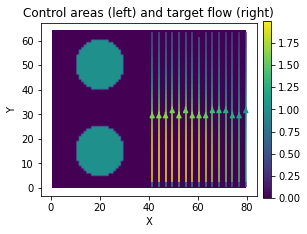

In [36]:
res = dict(x=80, y=64)
control_area = union(Sphere(x=20, y=15, radius=10), Sphere(x=20, y=50, radius=10))
control_mask = StaggeredGrid(control_area, 0, **res)
target_mask = StaggeredGrid(Box(x=(40, INF), y=None), 0, **res)
target = target_mask * StaggeredGrid(lambda x: math.exp(-0.5 * math.vec_squared(x - (50, 10), 'vector') / 32**2), 0, **res) * (0, 2)
plot(control_mask['x'], target, overlay='args', size=(4, 3), title='Control areas (left) and target flow (right)')

To optimize the control flow, we first define the loss function and get its derivative.

In [22]:
@jit_compile
def loss(v0):
    v1, p = fluid.make_incompressible(v0 * control_mask)
    return field.l2_loss((v1 - target) * target_mask), v1, p

grad_fun = field.functional_gradient(loss, wrt='v0', get_output=True)

Now, we can iteratively apply gradient descent steps in order to reduce the loss.

In [27]:
def gradient_descent_step(v0, _l, _v, step_size=1.):
    (loss, v, p), dv0 = grad_fun(v0)
    return v0 - step_size * dv0, loss, v

velocity_fit = StaggeredGrid(Noise(), 0, **res) * 0.1 * control_mask
ctrl_trj, loss_trj, v_trj = iterate(gradient_descent_step, batch(iter=20), velocity_fit, None, None, range=trange)

  0%|          | 0/20 [00:00<?, ?it/s]

Let's see how the loss is evolving.

<Figure size 216x216 with 1 Axes>

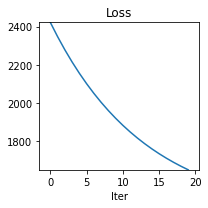

In [31]:
plot(loss_trj.iter.as_spatial(), size=(3, 3), title="Loss")

And we can visualize how the full flow field changes during the optimization.

In [32]:
plot(control_area, v_trj, overlay='args', animate='iter', frame_time=200, size=(5, 4))